In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [2]:
swe_cod = pd.read_csv("data/SWE_m_short_idr.csv")

2022
0.0888800089858106
-0.022464824268281135
34.94749725108839


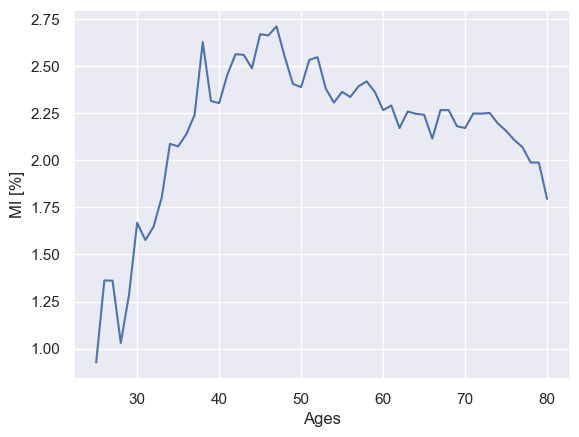

In [70]:
min_age           = 25 # not lower than 25, Gompertz law for mortality
max_age           = 80 # not higher than 80
min_year          = 1980
max_year          = 2019
max_forecast_year = 2022
sex               = "m"
country           = "SWE"

df = pd.read_csv("data/" + country + "_" + sex + ".txt", sep='\s+', header=1)
df = df.loc[df["Age"] != "110+"]
df = df.copy()
df["Age"] = df["Age"].astype('int')
df = df.loc[(df["Year"] >= min_year) & (df["Year"] <= max_forecast_year) & (df["Age"] >=  min_age) & (df["Age"] <=  max_age)]
df = df[["Age", "Year", "qx"]]
df = df.sort_values(by=["Age", "Year"])
df_fit = df.loc[df["Year"] <= max_year]
print(np.max(df["Year"]))

ages = df["Age"].unique()
years = df["Year"].unique()

a = np.linalg.lstsq(np.vstack([df_fit["Age"], df_fit["Year"], np.ones(df_fit.shape[0])]).T, np.log(df_fit["qx"]), rcond=None)

print(a[0][0])
print(a[0][1])
print(a[0][2])

mi = np.round((1 - np.exp(a[0][1]))*100, 2)

qx_dev =    (
                np.exp(
                 np.log(np.array(df["qx"]).reshape(len(ages), len(years)))
                 - a[0][0]*np.array(df["Age"]).reshape(len(ages), len(years))
                 - a[0][1]*np.array(df["Year"]).reshape(len(ages), len(years))
                 - a[0][2]
                ) - 1
            ) * 100

fig = go.Figure(data=[go.Surface(z=qx_dev, y=ages, x=years, colorscale ="Picnic")])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                highlightcolor="limegreen", project_z=True))

fig.update_layout(title='Mortality deviations {country} {sex} [%], avg MI {mi:.2f}%'.format(country = country, sex="males" if sex == "M" else "females", mi=mi),
                autosize=True,
                scene = dict(                    
                xaxis_title="year",
                yaxis_title="age",
                zaxis_title="mortality deviation [%]"),
                width=900, height=900,
                scene_aspectratio=dict(x=1, y=1, z=1))

fig.show()


fig = go.Figure(data=go.Heatmap(z=qx_dev, y=ages, x=years, colorscale ="Picnic", zmin=-50, zmax=50))
fig.update_layout(title='Mortality deviations {country} {sex} [%], avg MI {mi:.2f}%'.format(country = country, sex="males" if sex == "M" else "females", mi=mi),
                autosize=True,                    
                scene = dict(                    
                xaxis_title="year",
                yaxis_title="age",
                zaxis_title="mortality deviation [%]"),                    
                width=900, height=500,
                margin=dict(l=30, r=30, b=35, t=30),
                scene_aspectratio=dict(x=1, y=1, z=1))

fig.show()

mi = np.zeros(len(ages))
for j, age in enumerate(ages):
    lv = df["Age"] == age
    a = np.linalg.lstsq(np.vstack([df.Year[lv], np.ones((1,sum(lv)))]).T, np.log(df.qx[lv]), rcond=None)
    mi[j] = (1-np.exp(a[0][0]))*100

sns.set()
plt.figure()
plt.plot(ages, mi)
plt.xlabel("Ages")
plt.ylabel("MI [%]")
plt.show()

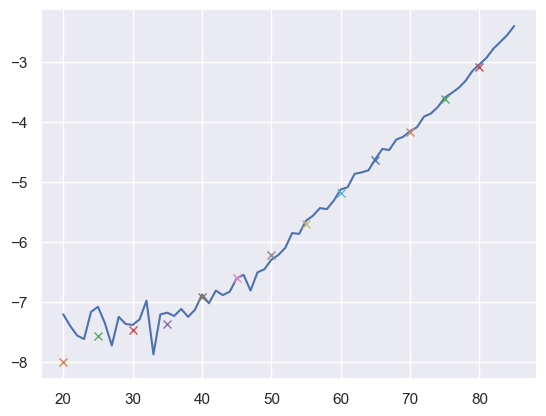

In [38]:
year = 2019

df = pd.read_csv("data/SWE_m.txt", sep="\s+", header=1)
swe_cod_agg = (
    swe_cod.drop(columns=["country", "list", "agf", "cause", "m95", "m95p", "m100p"])
    .groupby(["year", "sex"])
    .agg("sum")
    .reset_index()
)



df = df.loc[df["Age"] != "110+"]
df = df.copy()
df["Age"] = df["Age"].astype("int")
lv = (df["Year"] == year) & (df["Age"] >= 20) & (df["Age"] <= 85)

plt.figure()
plt.plot(df[lv]["Age"], np.log(df[lv]["qx"]))

lv = (swe_cod_agg["year"] == year) & (swe_cod_agg["sex"] == 2) # 2 = males
for x in np.arange(20,85,5):
    plt.plot(x, np.log(swe_cod_agg[lv]["m"+str(x-5)]/1e6), 'x') # not sure why x-5 works so well, coincidence?s
plt.show()

Age 30: 2.26% annual improvements
Age 40: 3.42% annual improvements
Age 50: 2.89% annual improvements
Age 60: 3.09% annual improvements
Age 70: 3.95% annual improvements
Age 80: 3.77% annual improvements


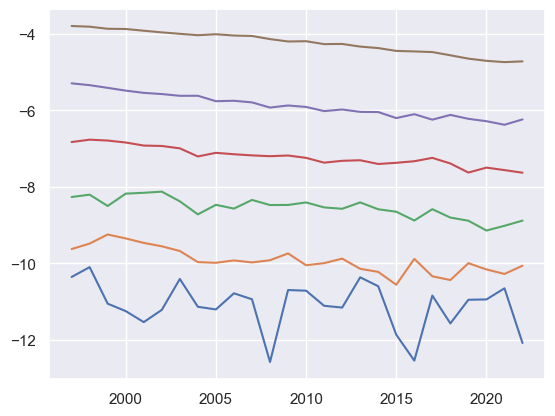

In [78]:
# using S007 as CVD
lv = (swe_cod["cause"] == "S007") & (swe_cod["sex"] == 2)
plt.figure()
for x in np.arange(30, 81, 10):
    plt.plot(swe_cod[lv]["year"], np.log(swe_cod[lv]["m" + str(x)] / 1e6))
    a = np.linalg.lstsq(
        np.vstack([swe_cod[lv]["year"], np.ones(np.sum(lv))]).T,
        np.log(swe_cod[lv]["m" + str(x)] / 1e6),
        rcond=None,
    )
    print("Age " + str(x) + ": " + str(np.round((1 - np.exp(a[0][0])) * 100, decimals = 2)) + "% annual improvements")
plt.show()

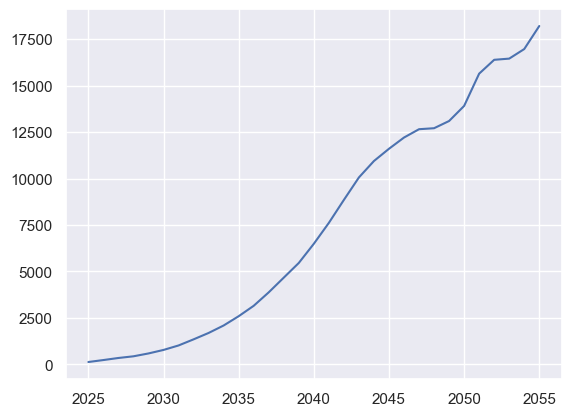

In [127]:
# model for Sweden -> to be scaled to Finland later
year = 2019  # year for mortality rates, CVD mortality
start_year = 2025
end_year = 2055
min_age = 20
max_age = 85
sex     = "m"
mi      = 0.02 # annual mortality improvements
cvdi    = 0.03 # annual CVD mortality improvements

# mortality
df = pd.read_csv("data/SWE_" + sex + ".txt", sep="\s+", header=1)
df = df.loc[df["Age"] != "110+"]
df = df.copy()
df["Age"] = df["Age"].astype("int")
df = df.loc[(df["Year"] == year) & (df["Age"] >= min_age) & (df["Age"] <= max_age)]
df = df[["Age", "Year", "qx"]]
df = df.sort_values(by=["Age", "Year"])
qx = np.array(df["qx"])

# exposures
df = pd.read_csv("data/SWE_E.txt", sep="\s+", header=1)
df = df.loc[df["Age"] != "110+"]
df = df.copy()
df["Age"] = df["Age"].astype("int")
df = df.loc[
    (df["Year"] == df["Year"].max()) & (df["Age"] >= min_age) & (df["Age"] <= max_age)
]
df = df.sort_values(by=["Age", "Year"])
Ex = np.array(df["Male"] if sex == "m" else df["Female"])

ages = np.arange(min_age, max_age + 1)
years = np.arange(start_year, end_year + 1)

transition_matrix = np.array(
    [
        # From:    Healthy_W    Healthy_U    PostCVD_W   PostCVD_U   RecCVD_W    RecCVD_U   Death
        [0.93, 0.05, 0.015, 0.005, 0.000, 0.000, 0.000],  # Healthy_W
        [0.10, 0.85, 0.02, 0.03, 0.000, 0.000, 0.000],  # Healthy_U
        [0.00, 0.00, 0.85, 0.10, 0.03, 0.02, 0.00],  # PostCVD_W
        [0.00, 0.00, 0.05, 0.80, 0.05, 0.08, 0.02],  # PostCVD_U
        [0.00, 0.00, 0.00, 0.00, 0.70, 0.25, 0.05],  # RecCVD_W
        [0.00, 0.00, 0.00, 0.00, 0.10, 0.75, 0.15],  # RecCVD_U
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00],  # Death
    ]
)

states = np.zeros((len(ages), 7, len(years)))
states[:, 0, 0] = Ex
for x in np.arange(len(ages)):
    transition_matrix[0, -1] = qx[x]
    transition_matrix[0, :-1] =  transition_matrix[0, :-1]/np.sum(transition_matrix[0, :-1])*(1-transition_matrix[0, -1])
    states[x, :, 0] = np.matmul(states[x, :, 0], transition_matrix)
for t in np.arange(1, len(years)):
    states[1:, :, t] = states[:-1, :, t - 1]
    states[0, 0, t] = Ex[0]
    for x in np.arange(len(ages)):
        transition_matrix[0, -1] = qx[x]
        transition_matrix[0, :-1] =  transition_matrix[0, :-1]/np.sum(transition_matrix[0, :-1])*(1-transition_matrix[0, -1])
        states[x, :, t] = np.matmul(states[x, :, t], transition_matrix)
    
plt.figure()
plt.plot(years, states[50-min_age, 6, :])
plt.show()

# TODOs
* Embed annual mortality improvements
* From CVD mortality to CVD incidence (copy age shape)
* Embed annual CVD mortality/incidence improvements
* Other transition matrix elements
* QALY, DALY, PALY vectors
* Interventions
* Visualizing results